In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import re
from glob import glob
import re
import kaleido
import nltk
from scipy.linalg import eigh, norm
import plotly_express as px
from sklearn.decomposition import PCA
import seaborn as sns
from gensim.models import word2vec
from sklearn.manifold import TSNE
from tqdm import tqdm
import re
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
epub_dir = 'epubs'

C:\Users\maria\AppData\Local\Temp\ipykernel_23336\1513247700.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import os
os.chdir("C:/Users/maria/OneDrive/Desktop/UVA Data Science/ETA/Final_Project")

In [3]:
TOKEN = pd.read_csv('TOKEN_final.csv').dropna()
LIB = pd.read_csv('LIB.csv')
VOCAB = pd.read_csv('VOCAB_final.csv').dropna()
DOC = pd.read_csv('DOC.csv').dropna()
#LOADING = pd.read_csv('LOADING.csv')

In [4]:
VOCAB.sample(10)

term_id  term_rank     term_str   n  num  stop stem_porter  \
2698      3943       2699    contagion  18    0     0   contagion   
14039     3436      14040     coliseum   1    0     0    coliseum   
2803     14766       2804   provincial  17    0     0    provinci   
14161    18658      14162       tanner   1    0     0      tanner   
15226    20546      15227      veteran   1    0     0     veteran   
9502     21336       9503      worsted   3    0     0       worst   
20966    14802      20967         puce   1    0     0        puce   
11840    20485      11841       venial   2    0     0      venial   
4123      6275       4124      enabled  10    0     0       enabl   
20829    14609      20830  prohibition   1    0     0    prohibit   

      stem_snowball stem_lancaster pos_max  term_rank2  
2698      contagion           cont      NN         418  
14039      coliseum         colise     NNP         435  
2803       provinci        provint      JJ         419  
14161        tanner            tan      NN         435  
15226       veteran            vet      NN         435  
9502          worst          worst     VBN         433  
20966          puce            puc      NN         435  
11840        venial            ven      NN         434  
4123          enabl             en     VBN         426  
20829      prohibit       prohibit      NN         435

**Computing Zipf's K**

In [5]:
VOCAB['p'] = VOCAB.n / VOCAB.shape[0]
VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank
VOCAB['zipf_k2'] = VOCAB.n * VOCAB.term_rank2
VOCAB['zipf_k3'] = VOCAB.p * VOCAB.term_rank2

In [6]:
VOCAB.describe().T

count          mean           std           min           25%  \
term_id     21529.0  10766.231455   6216.288788      1.000000   5383.000000   
term_rank   21529.0  10767.370245   6216.002777      1.000000   5384.000000   
n           21529.0     25.102699    336.518978      1.000000      1.000000   
num         21529.0      0.002973      0.054443      0.000000      0.000000   
stop        21529.0      0.006271      0.078940      0.000000      0.000000   
term_rank2  21529.0    423.272098     39.869771      1.000000    429.000000   
p           21529.0      0.001166      0.015631      0.000046      0.000046   
zipf_k      21529.0  29996.797622  12772.731337  13808.000000  19190.000000   
zipf_k2     21529.0   4152.879326   9276.316151    435.000000    435.000000   
zipf_k3     21529.0      0.192897      0.430875      0.020205      0.020205   

                     50%           75%           max  
term_id     10765.000000  16150.000000  21532.000000  
term_rank   10768.000000  16150.000000  21533.000000  
n               2.000000      7.000000  26880.000000  
num             0.000000      0.000000      1.000000  
stop            0.000000      0.000000      1.000000  
term_rank2    434.000000    435.000000    435.000000  
p               0.000093      0.000325      1.248548  
zipf_k      26746.000000  39320.000000  83521.000000  
zipf_k2       868.000000   3003.000000  83521.000000  
zipf_k3         0.040318      0.139486      3.879465

In [7]:
px.histogram(VOCAB, 'zipf_k', marginal='box',title= "Zipf's K", width = 700)

In [ ]:
px.histogram(VOCAB, 'zipf_k2', marginal='box', title="Zipf's K2")

In [ ]:
px.histogram(VOCAB, 'zipf_k3', marginal='box', title="Zipf's K3")

**Create**

In [8]:
count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth
gradient_cmap = 'GnBu'

In [9]:
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

In [10]:
unique_pos_values = TOKEN['pos'].unique()
print(unique_pos_values)

['NN' 'PRP' 'IN' 'DT' 'NNS' 'WDT' 'VBP' 'NNP' 'TO' 'RB' 'JJ' 'VBZ' 'RBR'
 'VB' 'RP' 'SYM' 'MD' 'VBG' 'WRB' 'CC' 'PRP$' 'CD' 'VBD' 'JJS' 'VBN' 'EX'
 'JJR' 'PDT' 'WP' 'FW' 'WP$' 'RBS' 'NNPS' 'POS' 'UH' "''" '$']


In [11]:
TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)

In [12]:
TOKEN.head()

book_id  chap_num  para_num  sent_num  token_num           pos_tuple  pos  \
0      144        27         1         0          0   ('CHAPTER', 'NN')   NN   
1      144        27         1         0          1        ('I', 'PRP')  PRP   
2      144        27         2         0          0        ('As', 'IN')   IN   
3      144        27         2         0          1       ('the', 'DT')   DT   
4      144        27         2         0          2  ('streets', 'NNS')  NNS   

  token_str term_str  term_id  
0   CHAPTER  chapter   2938.0  
1         I        i   9313.0  
2        As       as   1126.0  
3       the      the  18871.0  
4   streets  streets  18066.0

**POS tag distribution**

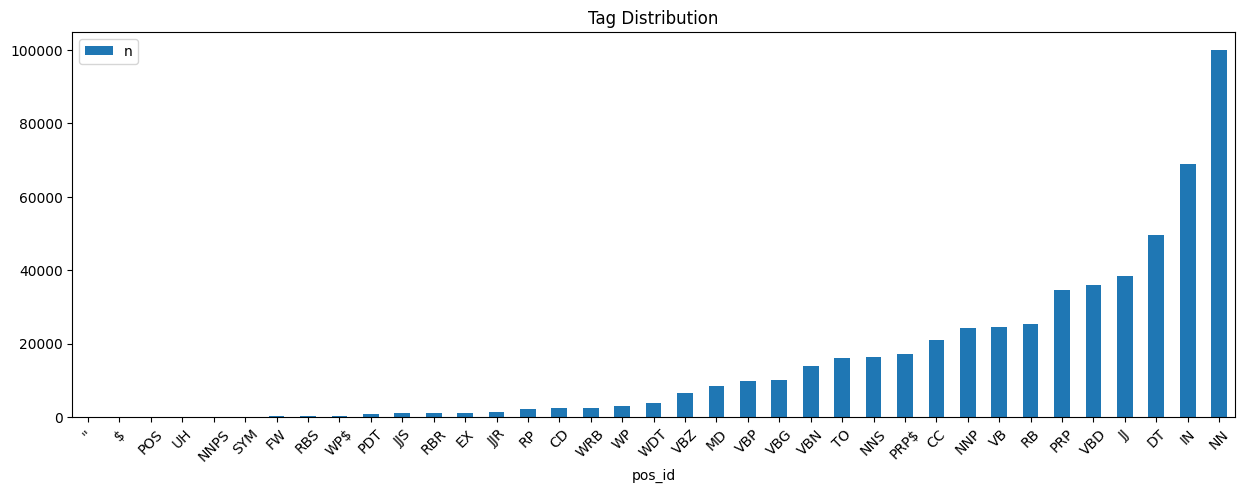

In [13]:
POS = TOKEN.pos.value_counts().to_frame().rename(columns={'pos':'n'})
POS.index.name = 'pos_id'
POS.sort_values('n').plot.bar(y='n', figsize=(15,5), rot=45, title="Tag Distribution");

In [ ]:
VOCAB.groupby('pos_max').n.sum().sort_values().plot.bar(figsize=(15,5));

**Creating TFIDF**

In [14]:
def tfidf_matrix(df, bag, count, tf_method, idf_method):
    '''
    Write a function that returns a TFIDF matrix, with the following arguments:
    df - The tokens data frame to use.
    bag - The OHCO level to use, e.g. which "bag" to use.
    count - The type of count to use (e.g. binary counts are regular counts).
    tf_method - The type of TF to use.
    idf_method - The type of IDF to use.
    '''

    #Bag Of Words 
    BOW = TOKEN.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})
    BOW['c'] = BOW.n.astype('bool').astype('int')

    #create count matrix 
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')

    #Compute TF

    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0]
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T

    #Compute DF
    DF = DTCM[DTCM > 0].count()
    #Compute IDF
    N = DTCM.shape[0]

    if idf_method == 'standard':
        IDF = np.log10(N / DF)
    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 
    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1

    #Compute TDIDF
    TFIDF = TF * IDF

    return(DF, IDF, TF, TFIDF, BOW)

In [15]:
VOCAB.head()

term_id  term_rank term_str      n  num  stop stem_porter stem_snowball  \
0    18871          1      the  26880    0     1         the           the   
1    12845          2       of  17206    0     1          of            of   
2      764          3      and  16460    0     1         and           and   
3    19145          4       to  16159    0     1          to            to   
4       65          5        a  11162    0     1           a             a   

  stem_lancaster pos_max  term_rank2         p  zipf_k  zipf_k2   zipf_k3  
0            the      DT           1  1.248548   26880    26880  1.248548  
1             of      IN           2  0.799201   34412    34412  1.598402  
2            and      CC           3  0.764550   49380    49380  2.293650  
3             to      TO           4  0.750569   64636    64636  3.002276  
4              a      DT           5  0.518463   55810    55810  2.592317

In [15]:
book_results = tfidf_matrix(TOKEN, BOOKS, count_method, tf_method, idf_method)

VOCAB['df'] = book_results[0]
VOCAB['idf'] = book_results[1]

TFIDF = book_results[3]

VOCAB['tfidf_sum'] = book_results[3].sum()

VOCAB = VOCAB.query('pos_max != "NNP"')
VOCAB = VOCAB.sort_values('tfidf_sum', ascending=False).head(4000)
terms = VOCAB.index.tolist()
TFIDF = TFIDF[terms]

In [16]:
TFIDF.head()

term_id   15034.0   8874.0    11320.0   5694.0    9006.0    12259.0   380.0    \
book_id                                                                         
144      0.001915  0.001336  0.000000  0.000000  0.000938  0.000568  0.000000   
145      0.000000  0.000000  0.001202  0.001177  0.000000  0.000355  0.000000   
18247    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000779   

term_id   9351.0    16108.0   2457.0   ...   19699.0   320.0     1587.0   \
book_id                                ...                                 
144      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
145      0.000000  0.000646  0.000593  ...  0.000000  0.000000  0.000000   
18247    0.000675  0.000000  0.000000  ...  0.000006  0.000006  0.000006   

term_id   8290.0    7984.0    21277.0   17974.0   7987.0    14673.0   17962.0  
book_id                                                                        
144      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
145      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
18247    0.000006  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006  

[3 rows x 4000 columns]

In [17]:
TFIDF.to_csv("TFIDF.csv")

In [18]:
VOCAB.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient(cmap=gradient_cmap, high=1)

In [19]:
VOCAB[['term_rank','term_str','pos_max','tfidf_sum']]\
    .sort_values('tfidf_sum', ascending=False).head(15)\
    .style.background_gradient(cmap=gradient_cmap, high=1)

In [20]:
px.scatter(VOCAB, x='term_rank', y='tfidf_sum', hover_name='term_str', hover_data=['n'], color='pos_max')

In [20]:
px.scatter(VOCAB, x='term_rank', y='tfidf_sum', hover_name='term_str', hover_data=['n'], color='pos_max', 
           log_x=True, log_y=True)

**PCA**

In [21]:
LIB

book_id      book_title  book_file                       author
0      144  The Voyage Out    144.txt               Virginia Woolf
1      145     Middlemarch    145.txt                 George Eliot
2    18247    The Last Man  18247.txt  Mary Wollstonecraft Shelley

In [22]:
#L2 Normalization
TFIDF = TFIDF.apply(lambda x: x / norm(x), 1)

#Center word vectors
TFIDF = TFIDF - TFIDF.mean()


#Compute Covariance Matrix
COV = TFIDF.cov()

COV.iloc[:5,:10].style.background_gradient()

In [23]:
# Decompose the Matrix
eig_vals, eig_vecs = eigh(COV)

#Convert Eigen Data to Dataframes
TERM_IDX = COV.index
EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)
EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
EIG_VAL.index.name = 'term_id'
EIG_VEC.iloc[:5, :10].style.background_gradient()

In [24]:
# Combine eigenvalues and eigenvectors into a single table.
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
EIG_PAIRS

eig_val   15034.0    8874.0   11320.0    5694.0    9006.0  \
term_id                                                                   
15034.0 -1.771872e-15  0.188779 -0.571082 -0.300241 -0.373876 -0.537786   
8874.0  -7.156216e-16 -0.226672  0.552698 -0.159407 -0.208135 -0.364008   
11320.0 -4.666673e-16 -0.392086  0.071972 -0.084899 -0.141394  0.015467   
5694.0  -3.255428e-16  0.470577  0.021063  0.279101  0.238467 -0.258968   
9006.0  -2.825617e-16 -0.191248 -0.080677 -0.142881 -0.010738  0.190307   
...               ...       ...       ...       ...       ...       ...   
21277.0  3.769729e-16  0.045338 -0.199394  0.063013 -0.075371  0.185568   
17974.0  4.839342e-16  0.064630 -0.229189 -0.186208 -0.062620  0.413455   
7987.0   1.789536e-15  0.036237 -0.010110 -0.651971  0.673038 -0.118569   
14673.0  4.765502e-01  0.462467  0.322579 -0.375993 -0.368240  0.226536   
17962.0  5.029896e-01 -0.300403 -0.209536 -0.180744 -0.177017 -0.147150   

          12259.0     380.0    9351.0   16108.0  ...   19699.0     320.0  \
term_id                                          ...                       
15034.0  0.034137 -0.149708 -0.197547 -0.012136  ... -0.000859 -0.000859   
8874.0  -0.169047 -0.012649 -0.119892  0.064617  ... -0.001960 -0.001960   
11320.0 -0.273462 -0.619094  0.224290 -0.233399  ...  0.000095  0.000095   
5694.0  -0.588432  0.098677  0.159580 -0.191109  ... -0.000306 -0.000306   
9006.0   0.025810  0.117858 -0.028319  0.029474  ...  0.000050  0.000050   
...           ...       ...       ...       ...  ...       ...       ...   
21277.0 -0.120703 -0.066177  0.026053  0.532073  ... -0.001536 -0.001536   
17974.0 -0.420318 -0.061051 -0.161869 -0.047943  ... -0.002117 -0.002117   
7987.0  -0.003050 -0.052932 -0.029074  0.008310  ... -0.000488 -0.000488   
14673.0  0.026189  0.032107  0.027818 -0.202117  ...  0.000245  0.000245   
17962.0 -0.142442  0.481080  0.416814 -0.097160  ...  0.003672  0.003672   

           1587.0    8290.0    7984.0   21277.0   17974.0    7987.0   14673.0  \
term_id                                                                         
15034.0 -0.000844 -0.000844 -0.000844 -0.000844 -0.000844 -0.000822 -0.000807   
8874.0  -0.002303 -0.002303 -0.002303 -0.002303 -0.002303 -0.002080 -0.001731   
11320.0  0.000074  0.000074  0.000074  0.000074  0.000074  0.000098 -0.000116   
5694.0  -0.000697 -0.000697 -0.000697 -0.000697 -0.000697 -0.000315 -0.000227   
9006.0   0.000054  0.000054  0.000054  0.000054  0.000054  0.000257  0.000197   
...           ...       ...       ...       ...       ...       ...       ...   
21277.0 -0.001862 -0.001862 -0.001862 -0.001862 -0.001862 -0.001622 -0.001382   
17974.0 -0.002781 -0.002781 -0.002781 -0.002781 -0.002781 -0.003237 -0.002563   
7987.0  -0.000449 -0.000449 -0.000449 -0.000449 -0.000449 -0.000395 -0.000432   
14673.0  0.000245  0.000245  0.000245  0.000245  0.000245  0.000245  0.000245   
17962.0  0.003672  0.003672  0.003672  0.003672  0.003672  0.003672  0.003672   

          17962.0  
term_id            
15034.0 -0.000796  
8874.0  -0.001793  
11320.0 -0.000052  
5694.0  -0.000148  
9006.0   0.000536  
...           ...  
21277.0 -0.001352  
17974.0 -0.002270  
7987.0  -0.000432  
14673.0  0.000245  
17962.0  0.003672  

[4000 rows x 4001 columns]

In [25]:
# calculates the explained variance for each principal component 
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

<AxesSubplot: xlabel='term_id'>

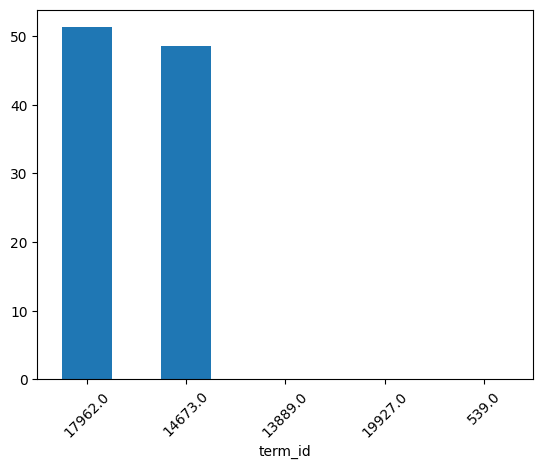

In [26]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45)

In [27]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]

In [28]:
VOCAB.loc[[int(x) for x in EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).index], 'term_str']
LOADINGS = COMPS[TERM_IDX].T
LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

LOADINGS.index.name = 'term_id'

In [29]:
LOADINGS.to_csv("LOADINGS.csv")

In [36]:
LOADINGS.head()

PC0       PC1       PC2           PC3       PC4           PC5  \
term_id                                                                       
15034.0 -0.300403  0.462467  0.000000  0.000000e+00  0.000000  0.000000e+00   
8874.0  -0.209536  0.322579  0.000008 -9.228649e-07  0.000022 -2.576714e-07   
11320.0 -0.180744 -0.375993  0.000007  4.765207e-07  0.000011 -1.342278e-05   
5694.0  -0.177017 -0.368240 -0.000003 -1.031559e-06  0.000010  2.630364e-05   
9006.0  -0.147150  0.226536  0.000005  1.419431e-06 -0.000003 -1.949829e-06   

                  PC6           PC7       PC8       PC9    term_str  
term_id                                                              
15034.0  0.000000e+00  0.000000e+00  0.000000  0.000000     strides  
8874.0   3.369861e-07 -4.883929e-06 -0.000028  0.000021    supplies  
11320.0  1.578443e-06 -7.833558e-06  0.000003  0.000003    shuffled  
5694.0  -1.035767e-05 -2.480441e-08  0.000003 -0.000007      soften  
9006.0   1.298109e-05 -3.061796e-06 -0.000014 -0.000007  infectious

In [28]:
l0_pos = LOADINGS.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
l0_neg = LOADINGS.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
l1_pos = LOADINGS.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
l1_neg = LOADINGS.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')
l2_pos = LOADINGS.sort_values('PC2', ascending=True).head(10).term_str.str.cat(sep=' ')
l2_neg = LOADINGS.sort_values('PC2', ascending=False).head(10).term_str.str.cat(sep=' ')

In [29]:
print('Books PC0+', l0_pos)
print('Books PC0-', l0_neg)
print('Books PC1+', l1_pos)
print('Books PC1-', l1_neg)
print('Books PC2+', l2_pos)
print('Books PC2-', l2_neg)

Books PC0+ strides supplies shuffled soften infectious avoiding wiout outward blank memorable
Books PC0- fine tense visitants hev suck amazement trembles voyager beneficently milk
Books PC1+ shuffled soften wiout outward blank fanatical gauged navigation satisfactions idols
Books PC1- strides supplies infectious mournings landholders lengthy anachronism law finely amanuensis
Books PC2+ meekly glory oy howlings paws starlight with biscuit dialogue leg
Books PC2- hulky abstain rushes wrestled orthodox unpacked leaning behoved fragments likable


In [30]:
DCM = TFIDF.dot(COMPS[TERM_IDX].T)

In [31]:
DCM=DCM.reset_index()

In [32]:
# top 10 eigenvalue-eigenvector pairs with the highest explained variance.
VOCAB.loc[[int(x) for x in EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).index], 'term_str']

17962       heritage
14673      cumberous
13889        chinked
19927           rove
539           struck
17690        pendent
795           morrow
4461         casting
10766    nonsensical
20287      sectarian
Name: term_str, dtype: object

In [33]:
pca_engine = PCA(n_components=3)

In [34]:
DCM_sk_b = pd.DataFrame(pca_engine.fit_transform(TFIDF), index=TFIDF.index)
DCM_sk_b.columns = ['PC{}'.format(i) for i in DCM_sk_b.columns]
DCM_sk_b['label'] = LIB.author
DCM_sk_b['title'] = LIB.book_title 
DCM_sk_b.head().style.background_gradient() 

In [35]:
# Reset indices of both DataFrames
DCM_sk_b_reset = DCM_sk_b.reset_index(drop=True)
LIB_reset = LIB.reset_index(drop=True)

# Assign 'author' and 'book_title' values to DCM_sk_b
DCM_sk_b_reset['label'] = LIB_reset['author']
DCM_sk_b_reset['title'] = LIB_reset['book_title']

# Apply background gradient to the modified DataFrame
styled_DCM = DCM_sk_b_reset.head().style.background_gradient()

In [36]:
styled_DCM

In [37]:
LOADINGS_sk = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS_sk.columns = ["PC{}".format(i) for i in LOADINGS_sk.columns]

In [38]:
LOADINGS_sk.index = TFIDF.columns
LOADINGS_sk.index.name = 'term_id'
LOADINGS_sk['term_str'] = LOADINGS_sk.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

In [39]:
pc0_pos = LOADINGS_sk.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
pc0_neg = LOADINGS_sk.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
pc1_pos = LOADINGS_sk.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')
pc1_neg = LOADINGS_sk.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')

In [40]:
print('BOOKS PC0+', pc0_pos)
print('BOOKS PC0-', pc0_neg)
print('BOOKS PC1+', pc1_pos)
print('BOOKS PC1-', pc1_neg)

BOOKS PC0+ fine tense visitants hev suck amazement trembles beneficently voyager milk
BOOKS PC0- strides supplies shuffled soften infectious avoiding wiout outward blank memorable
BOOKS PC1+ shuffled soften wiout outward blank fanatical gauged satisfactions navigation idols
BOOKS PC1- strides supplies infectious mournings landholders law finely anachronism lengthy amanuensis


In [41]:
def vis_pcs(M, a, b, prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color='label', 
                        hover_name='title', marginal_x='box')
    fig.show()

In [42]:
vis_pcs(DCM_sk_b_reset, 0,1)

**LDA**

In [43]:
n_terms = 4000
n_topics = 30
max_iter = 5
OHCO = ['book_id', 'chap_num', 'para_num']

In [44]:
BOOKS = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO[:1]).term_str\
    .apply(lambda x: ' '.join(x.astype(str)))\
    .to_frame()\
    .rename(columns={'term_str':'book_str'})

In [45]:
# Convert TOKENS to table of paragraphs
PARAS = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO).term_str\
    .apply(lambda x: ' '.join(x.astype(str)))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})

In [46]:
PARAS.head()

para_str
book_id chap_num para_num                                                   
144     27       1                                                   chapter
                 2         streets arm clerks leaps mud lady typists you ...
                 3         afternoon beginning traffic brisk man strode e...
                 4         embankment angles pulpits however boys string ...
                 5         river couple hour afternoon walking pleasure c...

**Create vector space**

In [47]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(PARAS.para_str)
TERMS = tfv.get_feature_names_out()

In [48]:
tfv2 = CountVectorizer(max_features=n_terms, stop_words='english')
tf2 = tfv.fit_transform(BOOKS.book_str)
TERMS2 = tfv.get_feature_names_out()

In [49]:
# Generate model
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
lda2 = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [50]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=PARAS.index)
THETA.columns.name = 'topic_id'

In [51]:
THETA2 = pd.DataFrame(lda2.fit_transform(tf2), index=BOOKS.index)
THETA2.columns.name = 'topic_id'

In [52]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

PHI2 = pd.DataFrame(lda2.components_, columns=TERMS)
PHI2.index.name = 'topic_id'
PHI2.columns.name  = 'term_str'

In [53]:
# Get top terms for topics
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

C:\Users\maria\AppData\Local\Temp\ipykernel_24940\2989178541.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\maria\AppData\Local\Temp\ipykernel_24940\2989178541.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\maria\AppData\Local\Temp\ipykernel_24940\2989178541.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\maria\AppData\Local\Temp\ipykernel_24940\2989178541.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\maria\AppData\Local\Temp\ipykernel_24940\2989178541.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

In [54]:
TOPICS2 = PHI2.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

C:\Users\maria\AppData\Local\Temp\ipykernel_24940\2856300834.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\maria\AppData\Local\Temp\ipykernel_24940\2856300834.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\maria\AppData\Local\Temp\ipykernel_24940\2856300834.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\maria\AppData\Local\Temp\ipykernel_24940\2856300834.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\maria\AppData\Local\Temp\ipykernel_24940\2856300834.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

<AxesSubplot: ylabel='label'>

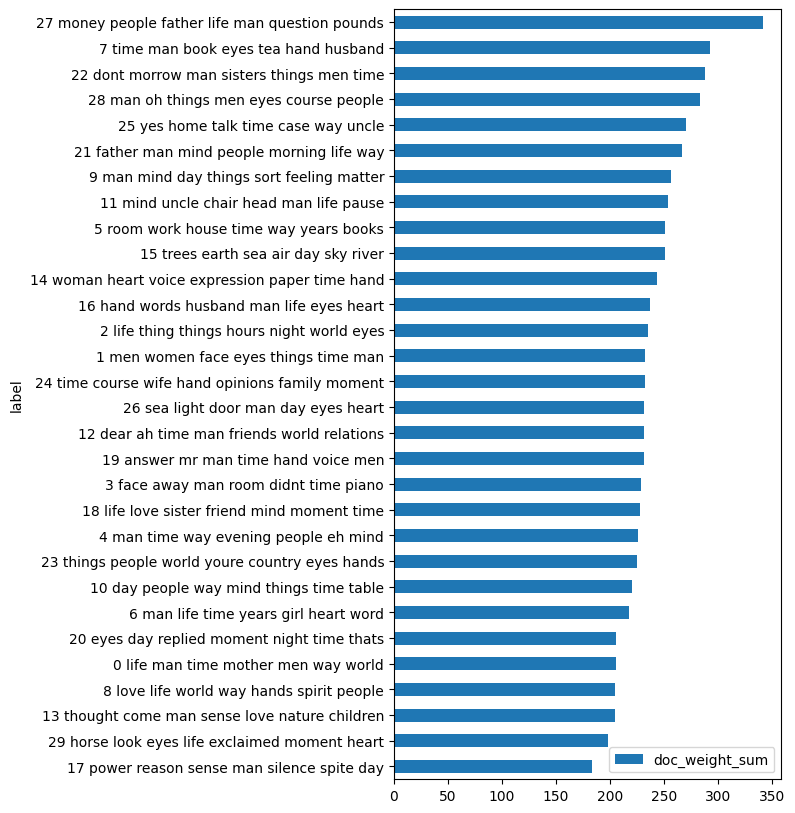

In [55]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x[:7].astype('str')), 1)
TOPICS2['label'] = TOPICS2.apply(lambda x: str(x.name) + ' ' + ' '.join(x[:7].astype('str')), 1)
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS2['doc_weight_sum'] = THETA2.sum()
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

<AxesSubplot: ylabel='label'>

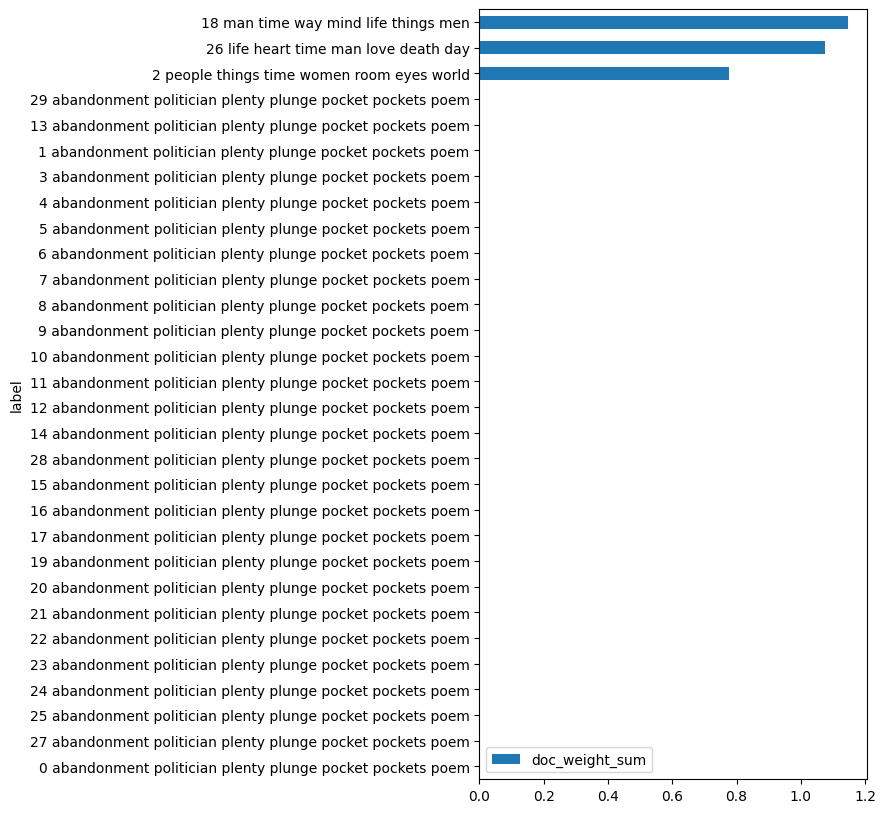

In [56]:
TOPICS2.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

In [57]:
topic_cols = [t for t in range(n_topics)]

In [58]:
joined_df = THETA.reset_index().merge(LIB, on='book_id', how='inner')

In [59]:
AUTHORS = joined_df.reset_index().set_index(['author'] + OHCO)\
                 .groupby('author')[topic_cols].mean()\
                 .T

AUTHORS.index.name = 'topic_id'
AUTHORS['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)


In [60]:
AUTHORS.head()

author    George Eliot  Mary Wollstonecraft Shelley  Virginia Woolf  \
topic_id                                                              
0             0.031194                     0.035704        0.020437   
1             0.027063                     0.045443        0.035652   
2             0.028953                     0.030593        0.040705   
3             0.028839                     0.021936        0.042239   
4             0.031302                     0.030969        0.032195   

author                                             topterms  
topic_id                                                     
0         life man time mother men way world day night w...  
1         men women face eyes things time man hand death...  
2         life thing things hours night world eyes youve...  
3         face away man room didnt time piano hat music ...  
4         man time way evening people eh mind hands thin...

In [61]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, 10))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [62]:
SIMS = pdist(normalize(PHI), metric='euclidean')
TREE = sch.linkage(SIMS, method='ward')

In [63]:
labels  = ["{}: {}".format(a,b) for a, b in zip(AUTHORS.index,  AUTHORS.topterms.tolist())]

<Figure size 640x480 with 0 Axes>

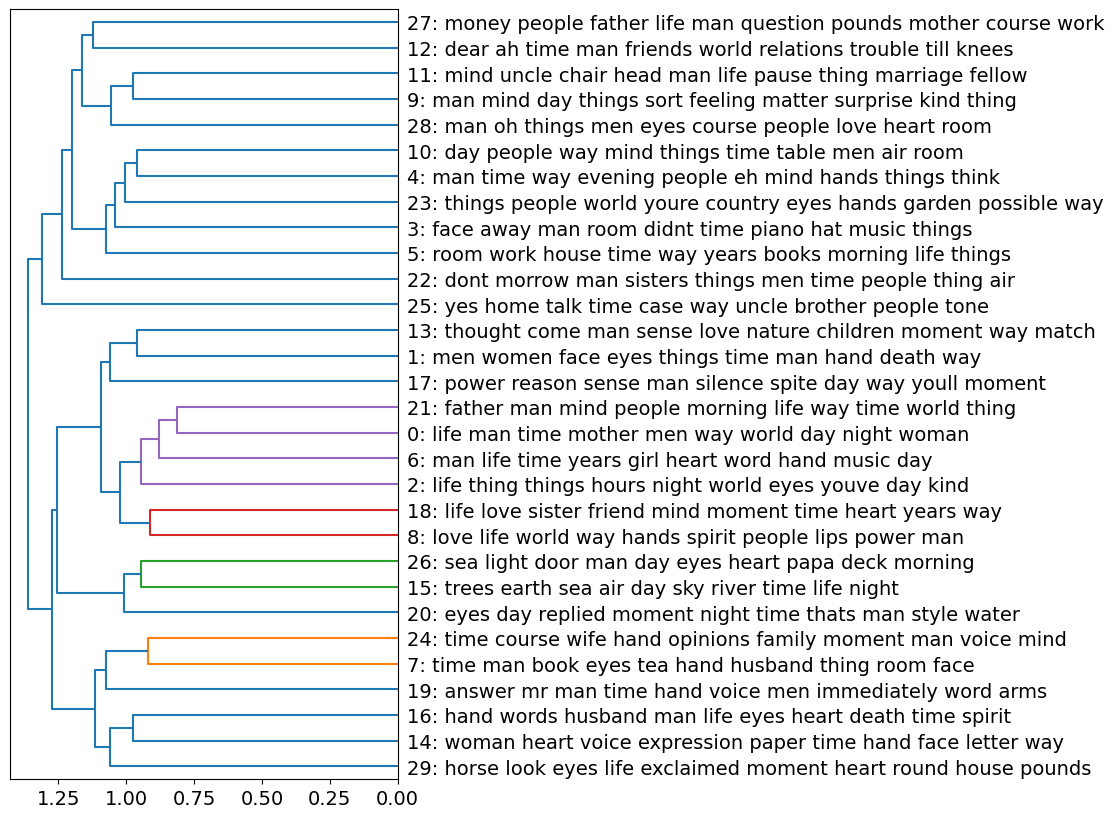

In [64]:
albero = plot_tree(TREE, labels)

**word2vec**

In [66]:
TOKEN = TOKEN.dropna()

In [67]:
TOKEN.head()

book_id  chap_num  para_num  sent_num  token_num           pos_tuple  pos  \
0      144        27         1         0          0   ('CHAPTER', 'NN')   NN   
1      144        27         1         0          1        ('I', 'PRP')  PRP   
2      144        27         2         0          0        ('As', 'IN')   IN   
3      144        27         2         0          1       ('the', 'DT')   DT   
4      144        27         2         0          2  ('streets', 'NNS')  NNS   

  token_str term_str  term_id  
0   CHAPTER  chapter   2938.0  
1         I        i   9313.0  
2        As       as   1126.0  
3       the      the  18871.0  
4   streets  streets  18066.0

In [68]:
WOOLF_TOKENS = TOKEN.query('book_id == 144')
ELIOT_TOKENS = TOKEN.query('book_id == 145')
SHELLEY_TOKENS = TOKEN.query('book_id == 18247')
#OHCO = ['book_id','chap_num','para_num','sent_num','token_num']
OHCO = ['book_id', 'chap_num', 'para_num']
BAG = OHCO[:3] #Paragraphs
#BAG = OHCO[:4] #Paragraphs
window = 5

In [ ]:
OHCO

In [69]:
VOCAB = VOCAB.dropna()

In [70]:
VOCAB.head()

term_id  term_rank    term_str  n  num  stop stem_porter stem_snowball  \
15034    18094      15035     strides  1    0     0      stride        stride   
8874     18389       8875    supplies  3    0     0      suppli        suppli   
11320    17014      11321    shuffled  2    0     0      shuffl        shuffl   
5694     17412       5695      soften  7    0     0      soften        soften   
9006      9813       9007  infectious  3    0     0     infecti       infecti   

      stem_lancaster pos_max  term_rank2         p  zipf_k  zipf_k2   zipf_k3  \
15034        strides     NNS         435  0.000046   15035      435  0.020205   
8874          supply     NNS         433  0.000139   26625     1299  0.060337   
11320         shuffl     VBD         434  0.000093   22642      868  0.040318   
5694            soft      VB         429  0.000325   39865     3003  0.139486   
9006         infecty      JJ         433  0.000139   27021     1299  0.060337   

        df       idf  tfidf_sum  
15034  1.0  0.477121   0.001915  
8874   1.0  0.477121   0.001336  
11320  1.0  0.477121   0.001202  
5694   1.0  0.477121   0.001177  
9006   1.0  0.477121   0.000938

In [71]:
ELIOT_TOKENS.head()

book_id  chap_num  para_num  sent_num  token_num          pos_tuple  \
112129      145        12         0         0          0    ('BOOK', 'NNP')   
112130      145        12         0         0          1     ('II.', 'NNP')   
112131      145        12         0         1          0     ('OLD', 'NNP')   
112132      145        12         0         1          1      ('AND', 'CC')   
112133      145        12         0         1          2  ('YOUNG.', 'NNP')   

        pos token_str term_str  term_id  
112129  NNP      BOOK     book   2135.0  
112130  NNP       II.       ii   9360.0  
112131  NNP       OLD      old  12884.0  
112132   CC       AND      and    764.0  
112133  NNP    YOUNG.    young  21469.0

In [72]:
corpusE = ELIOT_TOKENS[~ELIOT_TOKENS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

In [73]:
corpusW = WOOLF_TOKENS[~WOOLF_TOKENS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

In [74]:
corpusS = SHELLEY_TOKENS[~SHELLEY_TOKENS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

In [111]:
model_E = word2vec.Word2Vec(corpusE, vector_size=300, window=window, min_count=50, workers=4)
model_E.build_vocab(corpusE)

In [129]:
model_W = word2vec.Word2Vec(vector_size=200, window=window, min_count=20, workers=4)
model_W.build_vocab(corpusW)

In [153]:
model_S = word2vec.Word2Vec(vector_size=300, window=window, min_count=20, workers=4)
model_S.build_vocab(corpusS)

**Visualize with tSNE**

In [112]:
coords_E = pd.DataFrame(index=range(len(model_E.wv.key_to_index)))
coords_E['label'] = [w for w in model_E.wv.key_to_index]
coords_E['vector'] = coords_E['label'].apply(lambda x: model_E.wv.get_vector(x))

In [113]:
word_vectors_E = np.array(coords_E['vector'].tolist())
word_vectors_E_2d = word_vectors_E.reshape(len(word_vectors_E), -1)

tsne_modelE = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values_E = tsne_modelE.fit_transform(word_vectors_E_2d)


In [114]:
word_vectors_E = np.array(coords_E['vector'].tolist())
tsne_modelE = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values_E = tsne_modelE.fit_transform(word_vectors_E)

In [130]:
coords_W = pd.DataFrame(index=range(len(model_W.wv.key_to_index)))
coords_W['label'] = [w for w in model_W.wv.key_to_index]
coords_W['vector'] = coords_W['label'].apply(lambda x: model_W.wv.get_vector(x))

In [131]:
word_vectors_W = np.array(coords_W['vector'].tolist())
tsne_modelW = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values_W = tsne_modelW.fit_transform(word_vectors_W)

In [132]:
#try this new trick
word_vectors_W = np.array(coords_W['vector'].tolist())
word_vectors_W_2d = word_vectors_W.reshape(len(word_vectors_W), -1)

tsne_modelW = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values_W = tsne_modelW.fit_transform(word_vectors_W_2d)


In [154]:
coords_S = pd.DataFrame(index=range(len(model_S.wv.key_to_index)))
coords_S['label'] = [w for w in model_S.wv.key_to_index]
coords_S['vector'] = coords_S['label'].apply(lambda x: model_S.wv.get_vector(x))

In [155]:
#try this new trick
word_vectors_S = np.array(coords_S['vector'].tolist())
word_vectors_S_2d = word_vectors_S.reshape(len(word_vectors_S), -1)

tsne_modelS = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values_S = tsne_modelS.fit_transform(word_vectors_S_2d)


In [156]:
word_vectors_S = np.array(coords_S['vector'].tolist())
tsne_modelS = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values_S = tsne_modelS.fit_transform(word_vectors_S)

In [115]:
coords_E['x'] = tsne_values_E[:,0]
coords_E['y'] = tsne_values_E[:,1]

In [133]:
coords_W['x'] = tsne_values_W[:,0]
coords_W['y'] = tsne_values_W[:,1]

In [157]:
coords_S['x'] = tsne_values_S[:,0]
coords_S['y'] = tsne_values_S[:,1]

In [116]:
# plot the coordinates
px.scatter(coords_E, 'x', 'y', text='label', height=1000, width=1000, title="Middlemarch").update_traces(mode='text')

In [134]:
px.scatter(coords_W, 'x', 'y', text='label', height=1000, width=1000, title= "The Voyage Out").update_traces(mode='text')

In [158]:
px.scatter(coords_S, 'x', 'y', text='label', height=1000, width=1000, title="The Last Man").update_traces(mode='text')

**Sentiment analysis**

In [92]:
OHCO = ['author', 'book_title', 'chap_num', 'para_num', 'sent_num']
CHAPS = OHCO[2:3]
PARAS = OHCO[2:4]
SENTS = OHCO[2:5]

VoyageOut = ("Virginia Wolf","The Voyage Out")
MiddleMarch = ('Geoge Eliot', "Middlemarch")
LastMan = ("Mary Shelley", "The Last Man")

salex_csv = 'salex_nrc.csv'
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()
emo = 'polarity'

In [93]:
salex = pd.read_csv(salex_csv).set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]
salex['polarity'] = salex.positive - salex.negative
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [ ]:
salex

In [94]:
TOKEN.reset_index(inplace=True)

In [95]:
TOKEN = TOKEN.merge(LIB, on='book_id')

In [96]:
TOKEN = TOKEN.set_index(OHCO).sort_index()

In [97]:
TOKEN = TOKEN.join(salex, on='term_str', how='left')

In [98]:
TOKEN[emo_cols] = TOKEN[emo_cols].fillna(0)

In [99]:
TOKEN[salex.columns].sample(10)

anger  \
author                      book_title   chap_num para_num sent_num          
Mary Wollstonecraft Shelley The Last Man 48       2        8           0.0   
George Eliot                Middlemarch  102      55       4           0.0   
                                         144      86       0           0.0   
                                         155      56       3           0.0   
Mary Wollstonecraft Shelley The Last Man 38       18       7           0.0   
George Eliot                Middlemarch  128      34       1           0.0   
                                         93       12       3           0.0   
                                         102      3        1           0.0   
Mary Wollstonecraft Shelley The Last Man 41       19       5           0.0   
                                         33       20       4           0.0   

                                                                     anticipation  \
author                      book_title   chap_num para_num sent_num                 
Mary Wollstonecraft Shelley The Last Man 48       2        8                  0.0   
George Eliot                Middlemarch  102      55       4                  0.0   
                                         144      86       0                  0.0   
                                         155      56       3                  1.0   
Mary Wollstonecraft Shelley The Last Man 38       18       7                  0.0   
George Eliot                Middlemarch  128      34       1                  0.0   
                                         93       12       3                  0.0   
                                         102      3        1                  0.0   
Mary Wollstonecraft Shelley The Last Man 41       19       5                  0.0   
                                         33       20       4                  0.0   

                                                                     disgust  \
author                      book_title   chap_num para_num sent_num            
Mary Wollstonecraft Shelley The Last Man 48       2        8             0.0   
George Eliot                Middlemarch  102      55       4             0.0   
                                         144      86       0             0.0   
                                         155      56       3             0.0   
Mary Wollstonecraft Shelley The Last Man 38       18       7             0.0   
George Eliot                Middlemarch  128      34       1             0.0   
                                         93       12       3             0.0   
                                         102      3        1             0.0   
Mary Wollstonecraft Shelley The Last Man 41       19       5             0.0   
                                         33       20       4             0.0   

                                                                     fear  \
author                      book_title   chap_num para_num sent_num         
Mary Wollstonecraft Shelley The Last Man 48       2        8          0.0   
George Eliot                Middlemarch  102      55       4          0.0   
                                         144      86       0          0.0   
                                         155      56       3          0.0   
Mary Wollstonecraft Shelley The Last Man 38       18       7          0.0   
George Eliot                Middlemarch  128      34       1          0.0   
                                         93       12       3          0.0   
                                         102      3        1          0.0   
Mary Wollstonecraft Shelley The Last Man 41       19       5          0.0   
                                         33       20       4          0.0   

                                                                     joy  \
author                      book_title   chap_num para_num sent_num        
Mary Wollstonecraft Shelley The Last Man 48       2        8         0.0 

In [100]:
TOKEN[['term_str'] + emo_cols].sample(10)
TOKEN[emo_cols] = TOKEN[emo_cols].fillna(0)
TOKEN.head()

index  book_id  \
author       book_title  chap_num para_num sent_num                    
George Eliot Middlemarch 12       0        0         112129      145   
                                           0         112130      145   
                                           1         112131      145   
                                           1         112132      145   
                                           1         112133      145   

                                                     token_num  \
author       book_title  chap_num para_num sent_num              
George Eliot Middlemarch 12       0        0                 0   
                                           0                 1   
                                           1                 0   
                                           1                 1   
                                           1                 2   

                                                             pos_tuple  pos  \
author       book_title  chap_num para_num sent_num                           
George Eliot Middlemarch 12       0        0           ('BOOK', 'NNP')  NNP   
                                           0            ('II.', 'NNP')  NNP   
                                           1            ('OLD', 'NNP')  NNP   
                                           1             ('AND', 'CC')   CC   
                                           1         ('YOUNG.', 'NNP')  NNP   

                                                    token_str term_str  \
author       book_title  chap_num para_num sent_num                      
George Eliot Middlemarch 12       0        0             BOOK     book   
                                           0              II.       ii   
                                           1              OLD      old   
                                           1              AND      and   
                                           1           YOUNG.    young   

                                                     term_id book_file  anger  \
author       book_title  chap_num para_num sent_num                             
George Eliot Middlemarch 12       0        0          2135.0   145.txt    0.0   
                                           0          9360.0   145.txt    0.0   
                                           1         12884.0   145.txt    0.0   
                                           1           764.0   145.txt    0.0   
                                           1         21469.0   145.txt    0.0   

                                                     anticipation  disgust  \
author       book_title  chap_num para_num sent_num                          
George Eliot Middlemarch 12       0        0                  0.0      0.0   
                                           0                  0.0      0.0   
                                           1                  0.0      0.0   
                                           1                  0.0      0.0   
                                           1                  1.0      0.0   

                                                     fear  joy  negative  \
author       book_title  chap_num para_num sent_num                        
George Eliot Middlemarch 12       0        0          0.0  0.0       NaN   
                                           0          0.0  0.0       NaN   
                                           1          0.0  0.0       NaN   
                                           1          0.0  0.0       NaN   
                                           1          0.0  1.0       0.0   

                                                     positive  sadness  \
author       book_title  chap_num para_num sent_num                      
George Eliot Middlemarch 12       0        0              NaN      0.0   
                                           0              NaN      0.0   
                                           1              NaN      0.

In [101]:
TOKEN[['term_str'] + emo_cols].sample(10)

term_str  \
author                      book_title     chap_num para_num sent_num             
George Eliot                Middlemarch    145      1        3             with   
                                           96       19       0         disliked   
Mary Wollstonecraft Shelley The Last Man   50       15       6          receive   
George Eliot                Middlemarch    99       31       6                a   
Mary Wollstonecraft Shelley The Last Man   40       27       16            ills   
Virginia Woolf              The Voyage Out 43       30       3               of   
George Eliot                Middlemarch    104      5        1            forty   
                                           124      7        5            going   
                                           99       30       1         commerce   
Mary Wollstonecraft Shelley The Last Man   53       34       6               my   

                                                                       anger  \
author                      book_title     chap_num para_num sent_num          
George Eliot                Middlemarch    145      1        3           0.0   
                                           96       19       0           1.0   
Mary Wollstonecraft Shelley The Last Man   50       15       6           0.0   
George Eliot                Middlemarch    99       31       6           0.0   
Mary Wollstonecraft Shelley The Last Man   40       27       16          0.0   
Virginia Woolf              The Voyage Out 43       30       3           0.0   
George Eliot                Middlemarch    104      5        1           0.0   
                                           124      7        5           0.0   
                                           99       30       1           0.0   
Mary Wollstonecraft Shelley The Last Man   53       34       6           0.0   

                                                                       anticipation  \
author                      book_title     chap_num para_num sent_num                 
George Eliot                Middlemarch    145      1        3                  0.0   
                                           96       19       0                  0.0   
Mary Wollstonecraft Shelley The Last Man   50       15       6                  0.0   
George Eliot                Middlemarch    99       31       6                  0.0   
Mary Wollstonecraft Shelley The Last Man   40       27       16                 0.0   
Virginia Woolf              The Voyage Out 43       30       3                  0.0   
George Eliot                Middlemarch    104      5        1                  0.0   
                                           124      7        5                  0.0   
                                           99       30       1                  0.0   
Mary Wollstonecraft Shelley The Last Man   53       34       6                  0.0   

                                                                       disgust  \
author                      book_title     chap_num para_num sent_num            
George Eliot                Middlemarch    145      1        3             0.0   
                                           96       19       0             0.0   
Mary Wollstonecraft Shelley The Last Man   50       15       6             0.0   
George Eliot                Middlemarch    99       31       6             0.0   
Mary Wollstonecraft Shelley The Last Man   40       27       16            0.0   
Virginia Woolf              The Voyage Out 43       30       3             0.0   
George Eliot                Middlemarch    104      5        1             0.0   
                                           124      7        5             0.0   
                                           99       30       1             0.0   
Mary Wollstonecraft Shelley The Last Man   53       34       6             0.0   

                                                                       fear  \
auth

In [ ]:
TOKEN

In [102]:
Middle = TOKEN.loc[TOKEN['book_id']==145].copy()
Voyage = TOKEN.loc[TOKEN['book_id']==144].copy()
Man = TOKEN.loc[TOKEN['book_id']==18247].copy()

Text(0.5, 1.0, 'Middlemarch')

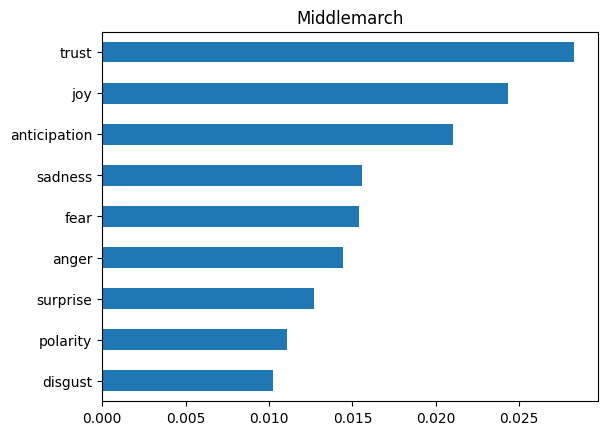

In [161]:
Middle[emo_cols].mean().sort_values().plot.barh()
plt.title("Middlemarch")

Text(0.5, 1.0, 'The Voyage Out')

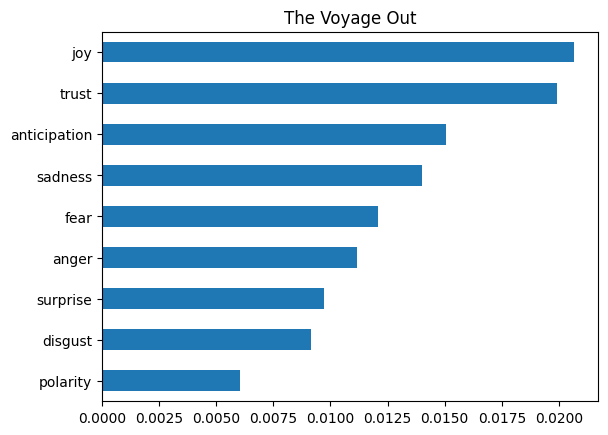

In [162]:
Voyage[emo_cols].mean().sort_values().plot.barh()
plt.title("The Voyage Out")

Text(0.5, 1.0, 'The Last Man')

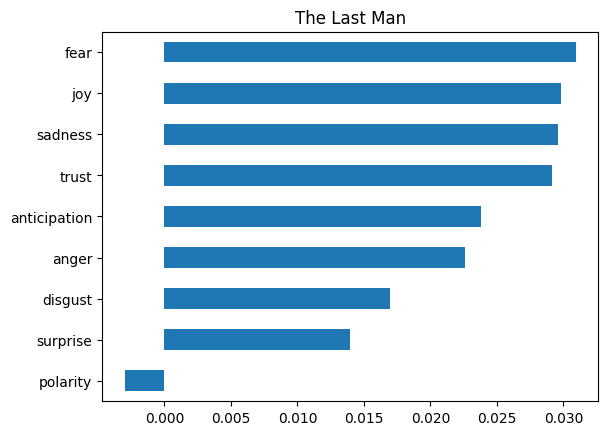

In [163]:
Man[emo_cols].mean().sort_values().plot.barh()
plt.title("The Last Man")

In [106]:
man_chaps = Man.groupby(CHAPS)[emo_cols].mean()
voyage_chaps = Voyage.groupby(CHAPS)[emo_cols].mean()
middle_chaps = Middle.groupby(CHAPS)[emo_cols].mean()

In [107]:
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

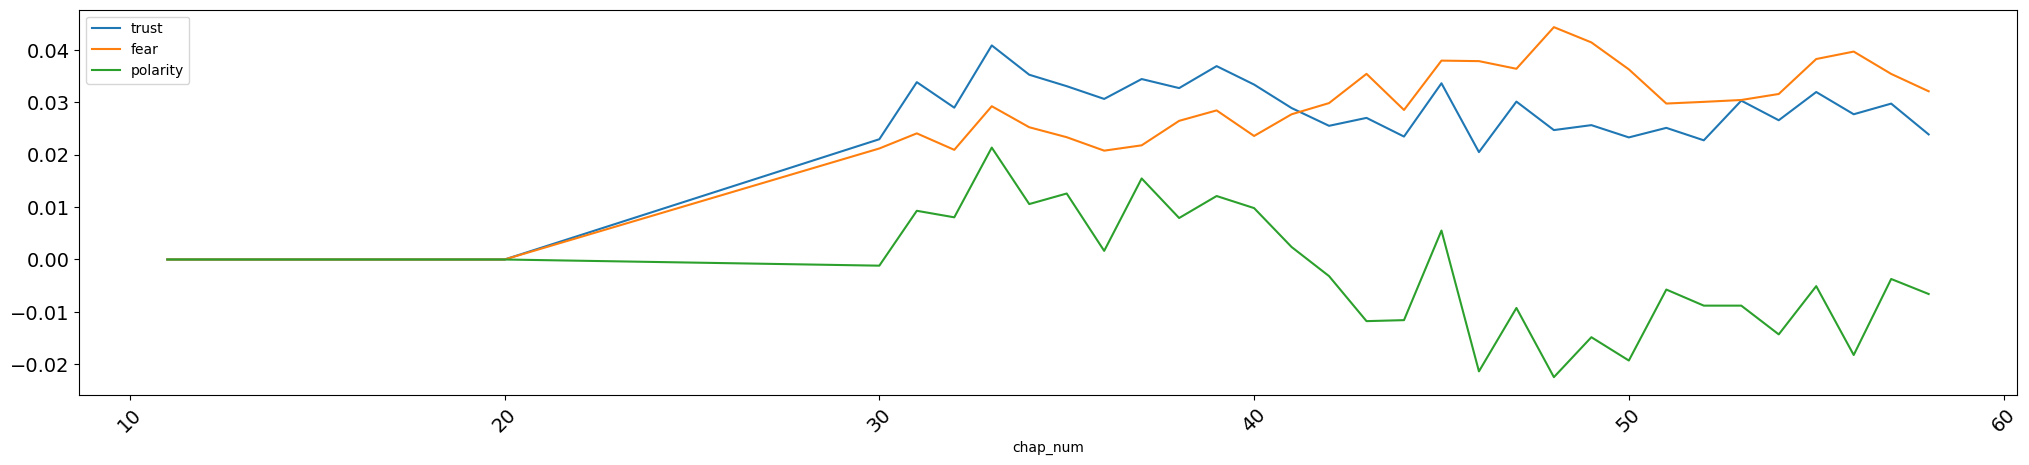

In [108]:
plot_sentiments(man_chaps, ['trust', 'fear', 'polarity'])

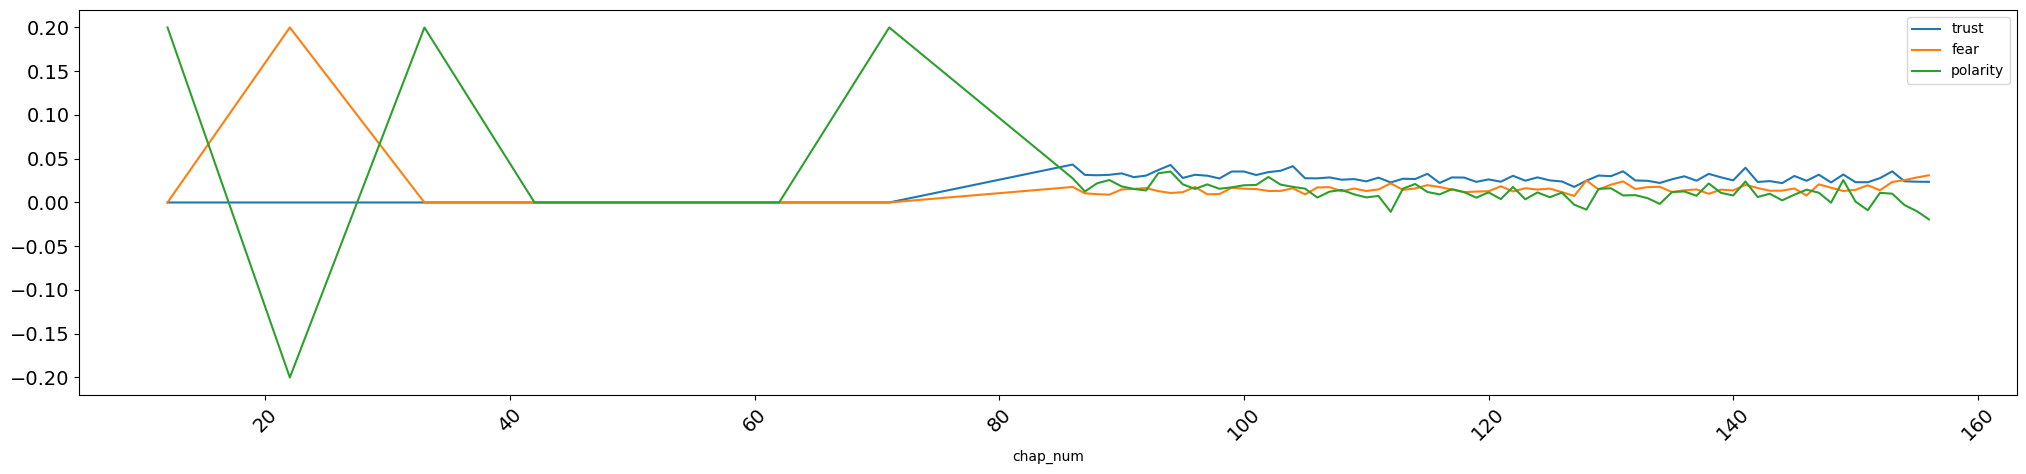

In [109]:
plot_sentiments(middle_chaps, ['trust', 'fear', 'polarity'])

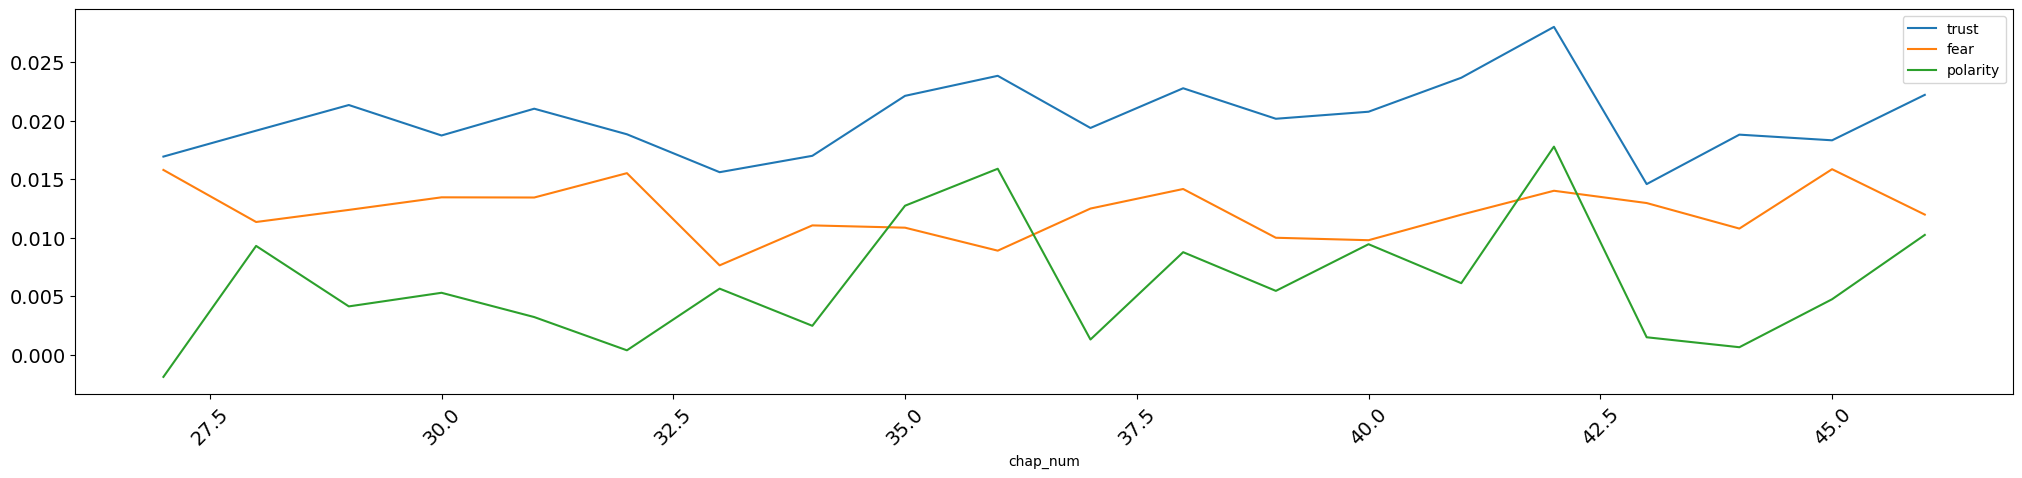

In [110]:
plot_sentiments(voyage_chaps, ['trust', 'fear', 'polarity'])